# Figures

In [1]:
import os
import nibabel as nb
import numpy as np
out_dir = '/home/shared/2018/visual/hcp_cerebellum/'

fig_dir = '/home/shared/2018/visual/hcp_cerebellum/figs/'

try:
    os.mkdir(fig_dir)
except:
    print 'figdir already exists'
    
import h5py
import matplotlib.pyplot as pl
import seaborn as sn
sn.set_style('ticks')
import glob
%matplotlib inline

import colorsys as cs

# note: dimensions in niftis:
# 0: angle
# 1: ecc
# 2: gain
# 3: meanvol
# 4: r2
# 5: size


figdir already exists


In [2]:
fns = glob.glob(os.path.join(out_dir,'best_subjects','*.nii'))


In [78]:
def p_val_from_bootstrap_dist(distribution,test_value=0,two_tailed=True):
    """
    Finds p-value for hypothesis that the distribution is not different 
    from the test_value.

    :param distribution: distribution of bootstrapped parameter
    :type distribution: 1-D array
    :param test_value: value to test distribution against
    :type test_value: float
    :param two_tailed: if True, returns two-tailed test, else one-tailed
    :type two_tailed: bool

    :return p-val: p-val
    :type p-val: float
    """

    # see which part of the distribution falls below / above test value:
    proportion_smaller_than_test_value = np.sum(np.array(distribution) < test_value) / len(distribution)
    proportion_larger_than_test_value = np.sum(np.array(distribution) > test_value) / len(distribution)

    # take minimum value as p-val:
    p = np.min([proportion_smaller_than_test_value,proportion_larger_than_test_value])

    # this yields a one-tailed test, so multiply by 2 if we want a two-tailed p-val:
    if two_tailed:
        p*=2

    return p

def get_ci(distribution,ci_factor):

    from scipy import stats
    
    # convert ci factor to percentile
    perc_low = (stats.norm.sf(ci_factor))*100
    perc_high = (1 - (stats.norm.sf(ci_factor)))*100
    ci_low = np.percentile(distribution,perc_low)
    ci_high = np.percentile(distribution,perc_high)

    return [ci_low,ci_high]

def bootstrap_linear_fit(x_data,y_data,weights=None,test_value=0,ci_factor = 1.96,two_tailed=True,reps=1000):
    """
    Fits linear regression to data, either weighted or not. 
    Returns bootstrapped CIs for slope and intercept


    """
    # # set weights to one if none provided 
    if weights is None:
        weights = np.ones(len(x_data))

    # get random ints for random indices
    permute_indices = np.random.randint(0, len(x_data), size = (len(x_data), int(reps))).T

    slope_bootstrap_distr=[]
    intercept_bootstrap_distr=[]
    # loop over permutes
    for fold in permute_indices:
        # compute weighted linear fit
        slope,intercept=np.polyfit(x_data[fold], y_data[fold], 1,w=weights[fold])
        slope_bootstrap_distr.append(slope)
        intercept_bootstrap_distr.append(intercept)

    # get centers for slope and intercept by fitting to all data
    mean_slope,mean_intercept=np.polyfit(x_data, y_data, 1,w=weights)
    # slope distribution diagnostics
    ci_slope = get_ci(slope_bootstrap_distr,ci_factor)
    # ci_slope = np.std(slope_bootstrap_distr)*ci_factor
    p_slope = p_val_from_bootstrap_dist(slope_bootstrap_distr,test_value,two_tailed)

    # intercept distribution diagnostics
    # ci_intercept = np.std(intercept_bootstrap_distr)*ci_factor
    ci_intercept = get_ci(intercept_bootstrap_distr,ci_factor)
    p_intercept = p_val_from_bootstrap_dist(intercept_bootstrap_distr,test_value,two_tailed)

    return mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept

# create retmap snapshots for different maskings:

In [9]:
# load  subject nifti
fns = glob.glob(os.path.join(out_dir,'best_subjects','*.nii'))

for fn in fns:
   
    data=nb.load(fn).get_data()
    
    sj = fn.split('/')[-1].split('_')[2]
    mask = fn.split('/')[-1].split('_')[4].split('.')[0]

    pl.figure(figsize=(15,5))
    pl.title(sj)
    data[data==0] = np.nan
    pl.subplot(131)
    pl.imshow(data[52,25:50,5:20,0].T,origin='lowerleft',cmap='hsv',clim=[0,360],interpolation='nearest')
    sn.despine(offset=10)
    pl.subplot(132)
    pl.imshow(data[30:60,38,5:20,0].T,origin='lowerleft',cmap='hsv',clim=[0,360],interpolation='nearest')
    sn.despine(offset=10)
    pl.subplot(133)
    pl.imshow(data[20:70,30:50,11,0].T,origin='lowerleft',cmap='hsv',clim=[0,360],interpolation='nearest')
    sn.despine(offset=10)

    pl.savefig(os.path.join(fig_dir,'volume_retmap_snapshots_sj_%s_mask_%s'%(sj,mask)))
    pl.close()


# create prf scatters

[  7  25  45  69  70 129 149 156 159 169]


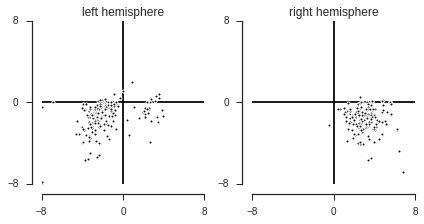

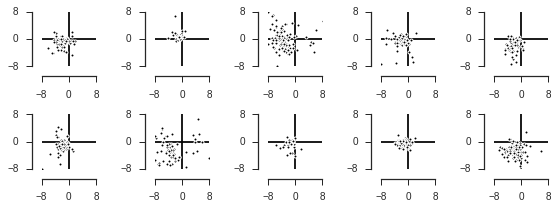

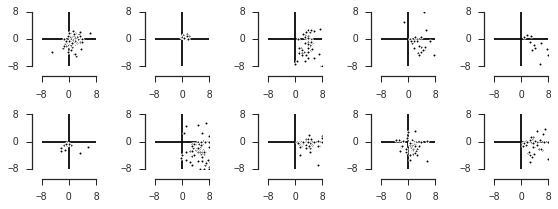

In [93]:
# load  subject nifti
fns = glob.glob(os.path.join(out_dir,'best_subjects','*.nii'))

best_subjects = np.array([int(fn.split('/')[-1].split('_')[2]) for fn in fns])
best_subjects = np.unique([s for s in best_subjects if not s in [181,182,183]])
print best_subjects

# all_subs_fig = pl.figure()

# colors = np.array([cs.hsv_to_rgb(c,0.6,0.9) for c in np.linspace(0,1,10+2)])[:-2]

mask = 'r2ecc'

# first create a plot for the average subject
f = pl.figure(figsize=(6,3))
for hi,hemi in enumerate(['left','right']):
    s = f.add_subplot(1,2,hi+1,aspect='equal')
    pl.title('%s hemisphere'%hemi)
    fn = os.path.join(out_dir,'best_subjects','prfresults_subject_183_mask_%s.nii'%mask)
    data=nb.load(fn).get_data()

    roimask = nb.load(os.path.join(out_dir,'%s_ventral.nii.gz'%hemi)).get_data().astype(bool)

    xs = np.cos(np.radians(np.ravel(data[roimask,0]))) * np.ravel(data[roimask,1])
    ys = np.sin(np.radians(np.ravel(data[roimask,0]))) * np.ravel(data[roimask,1])

    pl.axhline(0,color='k')
    pl.axvline(0,color='k')


    pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

    pl.xlim(-8,8)
    pl.ylim(-8,8)   
    pl.xticks([-8,0,8])
    pl.yticks([-8,0,8])
    sn.despine(offset=10)
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'prf_scatter_avg_subject.pdf'))



# # si-1
for hi,hemi in enumerate(['left','right']):

    f = pl.figure(figsize=(8,3))
    ecclim = 8
    for si, sj in enumerate(best_subjects):

        s = f.add_subplot(2,5,si+1,aspect='equal')
        fn = os.path.join(out_dir,'best_subjects','prfresults_subject_%d_mask_%s.nii'%(sj,mask))
        data=nb.load(fn).get_data()

        roimask = nb.load(os.path.join(out_dir,'%s_ventral.nii.gz'%hemi)).get_data().astype(bool)


        xs = np.cos(np.radians(np.ravel(data[roimask,0]))) * np.ravel(data[roimask,1])
        ys = np.sin(np.radians(np.ravel(data[roimask,0]))) * np.ravel(data[roimask,1])

        pl.axhline(0,color='k')
        pl.axvline(0,color='k')

        pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

        pl.xlim(-ecclim,ecclim)
        pl.ylim(-ecclim,ecclim)
        pl.xticks([-ecclim,0,ecclim])
        pl.yticks([-ecclim,0,ecclim])


        sn.despine(offset=10)
    pl.tight_layout()
    f.savefig(os.path.join(fig_dir,'prf_scatter_all_subjects_%s_hemi.pdf'%hemi))
        
        
        
        

In [10]:
# now ecc-size relations

[  7  25  45  69  70 129 149 156 159 169]
slope is 0.722 greater than 0 with p = 0.000
slope is 0.722 greater than 0 with p = 0.000
slope is 0.426 greater than 0 with p = 0.000
slope is 0.426 greater than 0 with p = 0.000
slope is 0.998 greater than 0 with p = 0.000
slope is 0.961 greater than 0 with p = 0.000
slope is 1.188 greater than 0 with p = 0.000
slope is 0.905 greater than 0 with p = 0.000
slope is 0.417 greater than 0 with p = 0.000
slope is 0.492 greater than 0 with p = 0.000
slope is 0.771 greater than 0 with p = 0.000
slope is 0.805 greater than 0 with p = 0.000
slope is 0.790 greater than 0 with p = 0.000
slope is 0.809 greater than 0 with p = 0.000
slope is 0.533 greater than 0 with p = 0.000
slope is 0.660 greater than 0 with p = 0.000
slope is 0.586 greater than 0 with p = 0.000
slope is 0.642 greater than 0 with p = 0.000
slope is 0.406 greater than 0 with p = 0.000
slope is 0.429 greater than 0 with p = 0.000


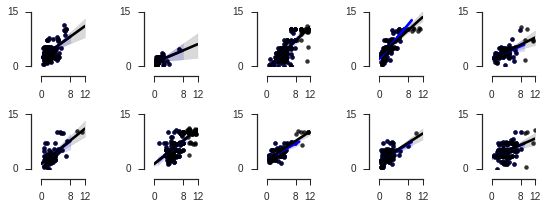

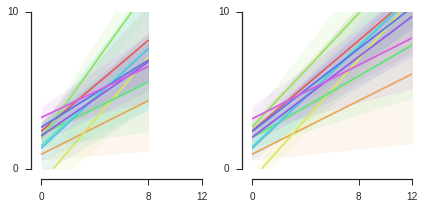

In [88]:
# load  subject nifti
fns = glob.glob(os.path.join(out_dir,'best_subjects','*.nii'))

roimask = nb.load(os.path.join(out_dir,'roi.nii')).get_data().astype(bool)


best_subjects = np.array([int(fn.split('/')[-1].split('_')[2]) for fn in fns])
best_subjects = np.unique([s for s in best_subjects if not s in [181,182,183]])
print best_subjects
# roimask = nb.load(os.path.join(out_dir,'roi.nii')).get_data().astype(bool)

# all_subs_fig = pl.figure()

colors = np.array([cs.hsv_to_rgb(c,0.6,0.9) for c in np.linspace(0,1,10+2)])[:-2]

mask = 'r2ecc'
f = pl.figure(figsize=(3,3))
s = f.add_subplot(111)
for ei, eccrange in enumerate([8,12]):
    
    # first create a plot for the average subject
    fn = os.path.join(out_dir,'best_subjects','prfresults_subject_183_mask_%s.nii'%mask)
    data=nb.load(fn).get_data()

    eccs = data[roimask,1]
    sizes = data[roimask,5]
    
    v = (eccs<eccrange)

    sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
    # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

pl.xlim(0,12)
pl.ylim(0,10)

pl.xticks([0,8,12])
pl.yticks([0,10])
sn.despine(offset=10)
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'ecc_size_avg_subject.pdf'))
pl.close()




# # si-1
f = pl.figure(figsize=(8,3))
ecclim = 8
for si, sj in enumerate(best_subjects):
    for ei, eccrange in enumerate([8,12]):

        s = f.add_subplot(2,5,si+1,aspect='equal')


        # first create a plot for the average subject
        fn = os.path.join(out_dir,'best_subjects','prfresults_subject_%d_mask_%s.nii'%(sj,mask))
        data=nb.load(fn).get_data()

        eccs = data[roimask,1]
        sizes = data[roimask,5]

        v = (eccs<eccrange)

        sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
        # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

        pl.xlim(0,12)
        pl.ylim(0,15)

        pl.xticks([0,8,12])
        pl.yticks([0,15])
    sn.despine(offset=10)
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'ecc_size_all_subjects.pdf'))

      
f = pl.figure(figsize=(6,3))
coefs = []

for si, sj in enumerate(best_subjects):
    for ei, eccrange in enumerate([8,12]):


        s = f.add_subplot(1,2,ei+1)


        # first create a plot for the average subject
        fn = os.path.join(out_dir,'best_subjects','prfresults_subject_%d_mask_%s.nii'%(sj,mask))
        data=nb.load(fn).get_data()

        eccs = data[roimask,1]
        sizes = data[roimask,5]

        v = (eccs<eccrange)*(~np.isnan(eccs))
        mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])
        
        x = np.linspace(0,eccrange,10)
        
        fit = mean_intercept + mean_slope * x
        high_fit = ci_intercept[1] + ci_slope[1] * x
        low_fit = ci_intercept[0] + ci_slope[0] * x

        pl.fill_between(x,high_fit,low_fit,color=colors[si],alpha=0.1)
        pl.plot(x,fit,c=colors[si])
        
        print 'slope is %.3f greater than 0 with p = %.3f'%(mean_slope,p_slope)

#         pl.plot(x,c.intercept_[0]+c.coef_[0][0]*x,c=colors[si])


    #         sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
    #         # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

        pl.xlim(0,12)
        pl.ylim(0,10)
    # /
        pl.xticks([0,8,12])
        pl.yticks([0,10])
        sn.despine(offset=10)
    
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'ecc_size_all_subjects_together.pdf'))     